# let's import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score
import collections

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# let's extract train

In [82]:
df = pd.read_csv('train.csv')
df.head(5)

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,21983,18,Private,141363,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,40,United-States,0
1,10063,38,Private,179579,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,?,1
2,16273,63,Private,172740,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0
3,2208,35,Private,47707,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Female,0,0,40,United-States,1
4,15914,32,Private,48458,HS-grad,9,Never-married,Sales,Own-child,Black,Female,0,1669,45,United-States,0


# let's transform data

In [59]:
df.dtypes

id                  int64
 age                int64
 workclass         object
 fnlwgt             int64
 education         object
 education-num      int64
 marital-status    object
 occupation        object
 relationship      object
 race              object
 sex               object
 capital-gain       int64
 capital-loss       int64
 hours-per-week     int64
 native-country    object
target              int64
dtype: object

In [60]:
df[:][' native-country'].unique().size

42

In [81]:
from sklearn.preprocessing import StandardScaler

In [58]:
def transform_df(df):
    df = df.rename(columns=lambda x: x.strip())
    n_col = []
    c_col = []
    for k,v in df.dtypes.to_dict().items():
        if v == 'int64':
            n_col.append(k)
        else:
            c_col.append(k)

    df[c_col] = df[c_col].apply(lambda x: x.str.strip(), axis=1)

    #sex
    df.sex.unique()
    df['sex_b'] = df['sex'].map({'Male':1, 'Female':0})
    df = df.drop(labels=['sex'], axis = 1)
    
    #married
    df['marital-status'].unique()
    #не была замужем, разведенка, вдова, разбежались 
    one = ['Never-married','Divorced','Widowed','Separated']
    #так или иначе женатики, гражданский и прочий браки
    two = ['Married-civ-spouse','Married-spouse-absent','Married-AF-spouse']
    df['marital-status_b'] = df['marital-status'].apply(lambda x: 1 if x in one else 0)
    df = df.drop(labels=['marital-status'], axis = 1)
    
    df = pd.get_dummies(df, columns=['marital-status_b', 'workclass', 'occupation', 'race'])
    
    df = df.drop(labels=['fnlwgt', 'education', 'relationship', 'native-country'], axis = 1)
    
    return df, c_col

In [59]:
df, c_col = transform_df(df)

In [35]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [60]:
df.columns.values

array(['id', 'age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'target', 'sex_b', 'marital-status_b_0',
       'marital-status_b_1', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'occupation_?', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'race_Amer-Indian-Eskimo',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
       'race_White'], dtype=object)

In [61]:
df.head(5)

,id,age,education-num,capital-gain,capital-loss,hours-per-week,target,sex_b,marital-status_b_0,marital-status_b_1,...,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,21983,18,10,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,10063,38,10,0,0,50,1,1,1,0,...,1,0,0,0,0,0,0,0,0,1
2,16273,63,10,0,0,40,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,2208,35,9,0,0,40,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,15914,32,9,0,1669,45,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0


In [25]:
c_col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

# let's try model

In [62]:
Y = df.target.values
X = df.drop(['target', 'id'], axis = 1).values
size = 0.2
seed = 10

X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=size,random_state=seed)

kfold = KFold(n_splits = 10, random_state = seed)

cv_res = cross_val_score(RandomForestClassifier(n_estimators = 100, max_features = 3), X_train, Y_train, cv=kfold, scoring = 'f1')

In [63]:
print(cv_res.mean(), cv_res.std())

0.15637437948571098 0.02427722944470885


# let's try to impove

In [44]:
n_estimators = np.array([50,100,200,250])
max_features = np.array([1,3,5])

grid_p = dict(n_estimators = n_estimators, max_features = max_features)
md = RandomForestClassifier()
kfold = KFold(10, random_state = 10)

grid_cv = GridSearchCV(estimator = md, param_grid = grid_p, scoring = 'f1', cv = kfold, n_jobs=-1)
grid_res = grid_cv.fit(X_train, Y_train)

means = grid_res.cv_results_['mean_test_score']
stds = grid_res.cv_results_['std_test_score']
params = grid_res.cv_results_['params']

In [46]:
for m,s,p in zip(means,stds,params):
    print(p,m,s)

{'max_features': 1, 'n_estimators': 50} 0.15828857101710445 0.026743729774877774
{'max_features': 1, 'n_estimators': 100} 0.1571575816181917 0.024678405972858686
{'max_features': 1, 'n_estimators': 200} 0.16144503081307163 0.029745554640233735
{'max_features': 1, 'n_estimators': 250} 0.16177826482413446 0.02507536729530834
{'max_features': 3, 'n_estimators': 50} 0.14924983322384686 0.02757639873522053
{'max_features': 3, 'n_estimators': 100} 0.1495676951184817 0.02983633485947272
{'max_features': 3, 'n_estimators': 200} 0.15285486797175257 0.026150051518114472
{'max_features': 3, 'n_estimators': 250} 0.15181109812466428 0.028283680094224915
{'max_features': 5, 'n_estimators': 50} 0.1477337174829903 0.02980830580922976
{'max_features': 5, 'n_estimators': 100} 0.15388799488639845 0.0254909442849229
{'max_features': 5, 'n_estimators': 200} 0.13602218941164798 0.02216313375577973
{'max_features': 5, 'n_estimators': 250} 0.13934583582174848 0.02508935240694647


In [50]:
md = RandomForestClassifier(n_estimators=250,max_features=5)
md.fit(X_train, Y_train)
prd = md.predict(X_validation)

print((100*accuracy_score(Y_validation, prd)))

71.19341563786008


# let's check test

In [64]:
df_t = pd.read_csv('test.csv')
df_t.head(5)

,id,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,18738,22,Private,110684,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States
1,14083,26,Local-gov,242464,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,3103,0,40,United-States
2,6172,47,Private,170850,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,4064,0,60,United-States
3,2821,32,Federal-gov,454508,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States
4,11725,37,Federal-gov,194630,Masters,14,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,United-States


In [65]:
df_t, c_col_t = transform_df(df_t)

In [66]:
df_t.columns.values

array(['id', 'age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'sex_b', 'marital-status_b_0',
       'marital-status_b_1', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'occupation_?', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'race_Amer-Indian-Eskimo',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
       'race_White'], dtype=object)

In [67]:
diff(df.columns.values, df_t.columns.values)

['target']

In [68]:
#df_t.drop(labels=c_col_t, axis = 1, inplace = True)

X_t = df_t.drop(['id'], axis = 1).values

prd_t = md.predict(X_t)

In [69]:
collections.Counter(prd_t)

Counter({0: 6120, 1: 649})

In [70]:
df_t['target'] = prd_t.tolist()
df_t['Index'] = df_t['id']
df_t[['Index','target']].to_csv("pkd.csv", header=['Index','target'], index=False)

In [73]:
import matplotlib.pyplot as plt

In [78]:
def plot_importance(clf, X):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(20, 8))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
#    plt.xticks(range(X.shape[1]), X.columns[indices])
    plt.xlim([-1, X.shape[1]])
    plt.show()

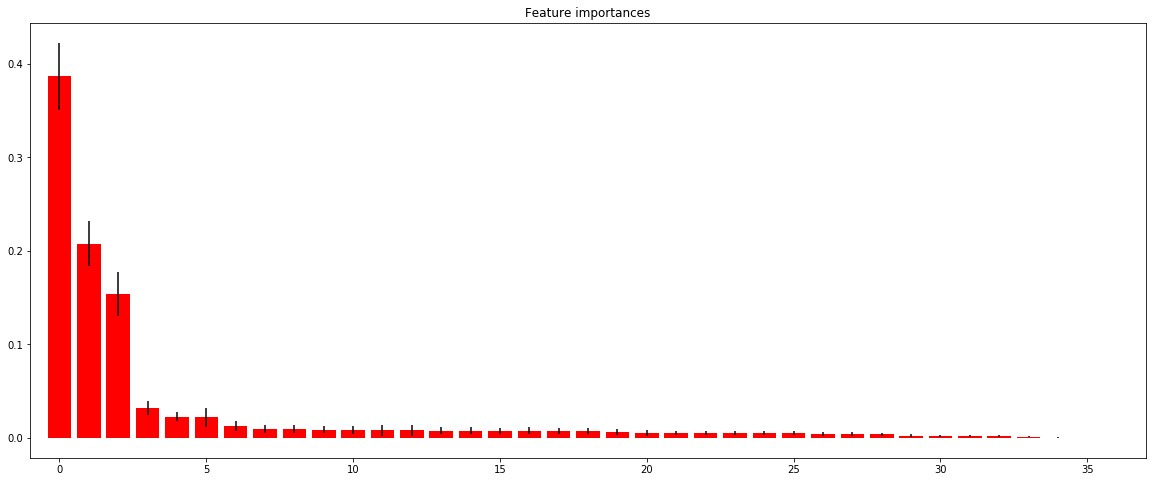

In [79]:
plot_importance(md, X_train)